Firstly, we need to import all of the libraries we are going to use and determine path for dataset storage.

In [30]:
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset

dataset_path = './modelsd'

We need to move our dataset from drive to local storage. This part of code should be skipped if dataset is already loaded to local storage or else it will call for an error.

In [ ]:
import shutil
import os

from google.colab import drive
drive.mount('/content/drive')
source_path = '/content/drive/MyDrive/CNN/RI'

shutil.move(source_path, dataset_path)

We need to load the datasets in variables - training_dataset, validation_dataset and testing_dataset. In constructor function of torchvision.dataset.Celeb(), parameter split determines the type of dataset - train, valid, test.
Upcoming code should be ran only if dataset hasn't been already downloaded.

In [32]:
training_dataset = torchvision.datasets.CelebA(dataset_path, split='train', target_type='attr', download=True)
validation_dataset = torchvision.datasets.CelebA(dataset_path, split='valid', target_type='attr', download=True)
testing_dataset = torchvision.datasets.CelebA(dataset_path, split='test', target_type='attr', download=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [33]:
print('Training set:', len(training_dataset))
print('Validation set:', len(validation_dataset))
print('Testing set:', len(testing_dataset ))

Training set: 162770
Validation set: 19867
Testing set: 19962


By printing out the lengths of this datasets, we can see how many images are stored in each one. We need to cut these numbers and take only a portion for each of these sets (for now, let's leave it like this because datasets variables will be changed soon).

We now want to compose image transformations, creating two separate transform variables, one for training and the other one for validation and testing. By doing these, we are using the technique of data augmentation which will increase the performance of our model.

In [34]:
training_transform = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAutocontrast(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

All of the above transformations, except Resize, are random (probability of them happening is 0.5). We do not want to apply transformations for all of the training data.
Note that we apply all of this random transformations only for transformation for training dataset.

We want to extract attribute young from attribute labels in dataset. The problem is, we don't know the index of our attribute. Let's find it.

In [35]:
all_attributes = training_dataset.attr_names
index_of_young = all_attributes.index("Young")
print("Index of 'young' attribute:", index_of_young)


Index of 'young' attribute: 39


Since we now have the index of young attribute, we can exctract it from dataset attributes, using the upcoming code (in code below, we didn't use variable index_of_young because code above doesn't have to be ran everytime and when it's not, it can throw exception).

In [36]:
extract_young = lambda attributes: attributes[39]

training_dataset = torchvision.datasets.CelebA(dataset_path, split='train', target_type='attr', download=False,
                                                transform=training_transform, target_transform=extract_young)
validation_dataset = torchvision.datasets.CelebA(dataset_path, split='valid', target_type='attr', download=False,
                                                 transform=transform, target_transform=extract_young)
testing_dataset = torchvision.datasets.CelebA(dataset_path, split='test', target_type='attr', download=False,
                                                  transform=transform, target_transform=extract_young)



We have created new variable that is actually lambda function which extracts attributes value at position index_of_young (young attribute). We need to instantiate our datasets again, while adding new parameters in constructor - transform and target_transform.
First one will apply transforms made in previous code block, while the second one is used for applying our lambda function extract_young to dataset, telling the dataset to focus only on the parameter/attribute with specified index - young.


As we have already seen, sizes of datasets are too large, so we need to make them smaller, with proportion of 7:2:1.

In [37]:
training_dataset = Subset(training_dataset, torch.arange(26000))
validation_dataset = Subset(validation_dataset, torch.arange(7200))
testing_dataset  = Subset(testing_dataset , torch.arange(3648))

print('Training set:', len(training_dataset))
print('Validation set:', len(validation_dataset))
print('Testing set:', len(testing_dataset ))

Training set: 26000
Validation set: 7200
Testing set: 3648


By printing out the sizes of dataset, we can see that they have been updated.

In [38]:
batch_size = 32

training_data_loader = DataLoader(training_dataset, batch_size, shuffle=True)
validation_data_loader = DataLoader(validation_dataset, batch_size, shuffle=False)
testing_data_loader = DataLoader(testing_dataset, batch_size, shuffle=False)

Here, we have created three separate DataLoader objects with appropriate datasets and batch_size previously set. This will help us, because from now on, datasets won't be used, only data loaders, allowing us to iterate through batches in training, validation and testing.

Now, when we are done with datasets and data loaders, let's create our model and it's layers.

In [39]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1))
model.add_module('batchnorm1', nn.BatchNorm2d(32))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.6))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1))
model.add_module('batchnorm2', nn.BatchNorm2d(64))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.4))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1))
model.add_module('batchnorm3', nn.BatchNorm2d(128))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1))
model.add_module('batchnorm4', nn.BatchNorm2d(256))
model.add_module('relu4', nn.ReLU())

model.add_module('pool4', nn.AvgPool2d(kernel_size=4, padding=0))
model.add_module('flatten', nn.Flatten())

model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())

There are four convolutional layers that create 32, 64, 128 and 256 feature maps with 3x3 dimensional kernel and padding set to 1 so that output feature map is same dimension as input. After each convolutional layer, there are batch normalization layers.
After each of the first three convolutional layers, there is a 2x2 max pooling layer.
We are also using dropout layers for regularization.
At the end, we add a global average pooling layer and fully connected layer.
Finally, we are adding sigmoid activation function.

Let's print out the model and see what it looks like.

In [40]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.6, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), paddi

Now, let's check the output for given tensor.

In [41]:
x = torch.ones((4, 3, 64, 64))
print(model(x).shape)

torch.Size([4, 1])


We can now conclude that our model is ready for binary classification.

We need to train this model using GPU, because by default, it's ran on CPU.

In [42]:
device = torch.device("cuda:0")
model = model.to(device)

From now on, we will need to use device and objects method .to(device) for batches and tensors.

Before the training, we need to setup the loss function and Adam optimizer for updating the parameters. We will use nn.BCELoss(), probability loss function used for binary classification. Learning rate will be set to 0.001.

In [43]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Before the implementation of training method, we should create method for saving the model to desired location and loading it if it's already been saved.

In [44]:
import os
def save_model(model, path):
  drive.mount('/content/drive', force_remount=True)
  directory = '/content/drive/MyDrive/SavedModels'
  os.makedirs(directory, exist_ok=True)
  torch.save(model, os.path.join(directory, path))

In [ ]:
def load_model():
  drive.mount('/content/drive', force_remount=True)
  directory = '/content/drive/MyDrive/SavedModels/first-try.ph'
  loaded_model = torch.load(directory)
  return loaded_model

We now finally get to train our model. train() method will have model, number of epochs and training and validation data loaders as parameters.

In [45]:
def train(model, num_epochs, training_data_loader, validation_data_loader):
    training_loss_hist, training_accuracy_hist, validation_loss_hist, validation_accuracy_hist = [], [], [], []
    for i in range(num_epochs):
        training_loss, training_accuracy, validation_loss, validation_accuracy = 0, 0, 0, 0

        model.train()
        for x_batch, y_batch in training_data_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            prediction = model(x_batch)[:, 0]
            loss = loss_fn(prediction, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            training_loss += loss.item()*y_batch.size(0)
            is_prediction_correct = ((prediction>=0.5).float() == y_batch).float()
            training_accuracy += is_prediction_correct.sum().cpu()

        training_loss /= len(training_data_loader.dataset)
        training_accuracy /= len(training_data_loader.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in validation_data_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                prediction = model(x_batch)[:, 0]
                loss = loss_fn(prediction, y_batch.float())
                validation_loss += loss.item()*y_batch.size(0)
                is_prediction_correct = ((prediction>=0.5).float() == y_batch).float()
                validation_accuracy += is_prediction_correct.sum().cpu()

        validation_loss /= len(validation_data_loader.dataset)
        validation_accuracy /= len(validation_data_loader.dataset)

        training_loss_hist.append(training_loss)
        training_accuracy_hist.append(training_accuracy)
        validation_loss_hist.append(validation_loss)
        validation_accuracy_hist.append(validation_accuracy)

        print(f'Epoch {i+1} train accuracy: {training_accuracy:.4f} validation accuracy: {validation_accuracy:.4f}')


    x_arr = np.arange(len(training_loss_hist)) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, training_loss_hist, '-o', label='Train loss')
    ax.plot(x_arr, validation_loss_hist, '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, training_accuracy_hist, '-o', label='Train acc.')
    ax.plot(x_arr, validation_accuracy_hist, '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)

We have implemented the most important method in code above, train().

*   Code is being run num_epochs times.
*   For every epoch, we put our model to training mode using model.train().
*   We iterate through training_data_loader, obtaining our batches.
*   Using those batches, we are getting prediction for current x_batch, will be used for calculating loss function and checking if prediction is correct.
*   After getting the loss function, using loss.backward(), gradients are being calculated using backpropagation
*   By using Adam optimizer methods step() and zero_grad(), we are updating parameters and then reseting parameters gradients to zero.
*   At the end of the training, we accumulate training accuracy and loss.
*   Next up is validation of model. Model is put in evaluation mode using model.eval()
*   Code logic for validation is pretty much the same as the one for training, while it doesn't include code for updating gradients and parameters, because in this stage, we only want to check for the accuracy of data in validation stage.
*   Lastly, we will draw plots for losses and accuracies.


Now we only need to implement method for testing our model.

In [50]:
def test(model):
  testing_accuracy = 0

  model.eval()
  with torch.no_grad():
      for x_batch, y_batch in testing_data_loader:
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          prediction = model(x_batch)[:, 0]
          is_prediction_correct = ((prediction>=0.5).float() == y_batch).float()
          testing_accuracy += is_prediction_correct.sum().cpu()

  testing_accuracy /= len(testing_data_loader.dataset)
  print(f'Test accuracy: {testing_accuracy:.4f}')
  visualize_test_results(x_batch, y_batch)


def visualize_test_results(x_batch_for_visualization, y_batch_for_visualization):
    prediction = model(x_batch_for_visualization)[:, 0] * 100
    fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(15, 20), gridspec_kw={'width_ratios': [0.3, 0.7]})

    for j in range(0, 10):

        ax_image = axes[j, 1]
        ax_text = axes[j, 0]

        ax_image.set_xticks([])
        ax_image.set_yticks([])
        ax_image.imshow(x_batch_for_visualization[j].cpu().permute(1, 2, 0))

        label = "Young" if y_batch_for_visualization[j] == 1 else "Old"
        prediction_percentage = f"{prediction[j]:.0f}%"
        classified_as = "Young" if prediction[j] >= 50 else "Old"
        text = f"Ground truth: {label:s}\nCNN classification: {classified_as}\n with the percentage of youngness {prediction_percentage}"
        ax_text.text(0.5, 0.5, text, size=16, ha="center", va="center")
        ax_text.axis("off")

    plt.tight_layout(pad=0)
    plt.show()

We have implemented two methods in code above.
Firstly, we implemented method test().

*   Model is firstly put in evaluation mode using model.eval()
*   Code is very similar to the one implemented for validation, with two major differencies being torch.no_grad() and no usage of loss function.
*   torch.no_grad() disables gradient calculating. It is mainly used in testing methods.
*   We iterate through training_data_loader, obtaining our batches.
*   Using those batches, we are getting prediction for current x_batch and by comparing results to ground truth, we update accuracy of testing.
*   Within that method, we call for other two.

Second method is visualize_test_results() and it shows up to 10 images from last batch in testing_data_loader. Every row in created plot shows image and text. Text contains informations about ground truth, image classification using CNN and prediction for it. This method helps us seeing actual results, not just the accuracy number.


Only thing remaining now is running the training method and checking the results.

Epoch 1 train accuracy: 0.7975 validation accuracy: 0.7908
Epoch 2 train accuracy: 0.8177 validation accuracy: 0.7789
Epoch 3 train accuracy: 0.8229 validation accuracy: 0.8213
Epoch 4 train accuracy: 0.8303 validation accuracy: 0.8196
Epoch 5 train accuracy: 0.8359 validation accuracy: 0.8206
Epoch 6 train accuracy: 0.8382 validation accuracy: 0.8258
Epoch 7 train accuracy: 0.8396 validation accuracy: 0.8036
Epoch 8 train accuracy: 0.8457 validation accuracy: 0.8214
Epoch 9 train accuracy: 0.8445 validation accuracy: 0.8290
Epoch 10 train accuracy: 0.8464 validation accuracy: 0.8403
Epoch 11 train accuracy: 0.8517 validation accuracy: 0.8415
Epoch 12 train accuracy: 0.8492 validation accuracy: 0.8381
Epoch 13 train accuracy: 0.8534 validation accuracy: 0.8403
Epoch 14 train accuracy: 0.8522 validation accuracy: 0.7985
Epoch 15 train accuracy: 0.8561 validation accuracy: 0.8410
Epoch 16 train accuracy: 0.8582 validation accuracy: 0.8429
Epoch 17 train accuracy: 0.8582 validation accura

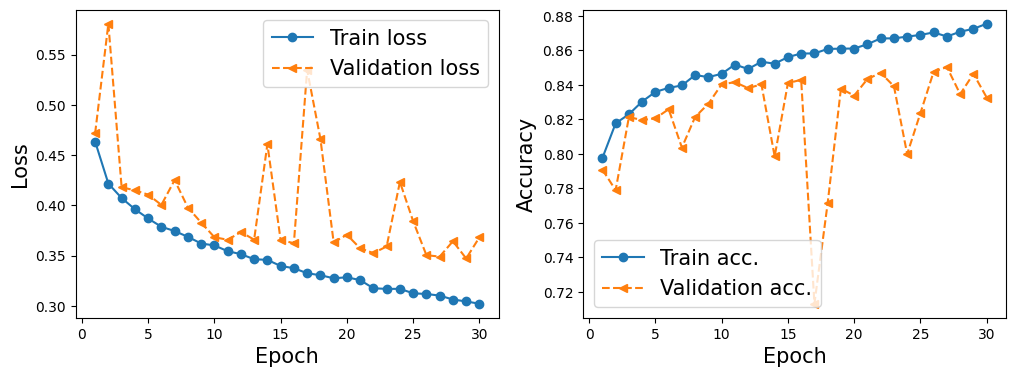

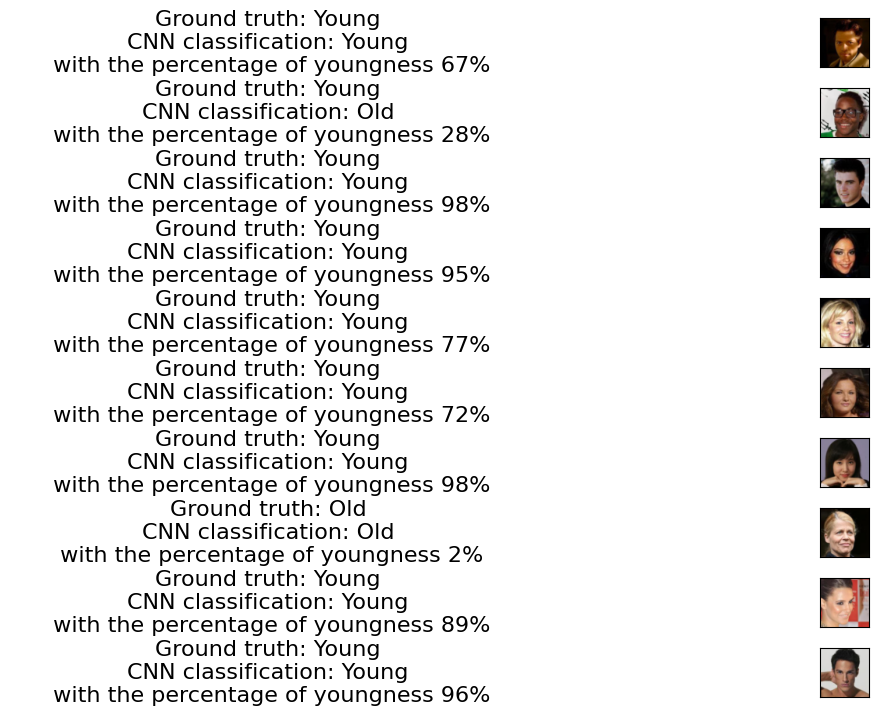

Mounted at /content/drive


In [47]:
torch.manual_seed(1)
num_epochs = 30
train(model, num_epochs, training_data_loader, validation_data_loader)
test(model)
save_model(model, "first-try.ph")

Mounted at /content/drive
Test accuracy: 0.8512


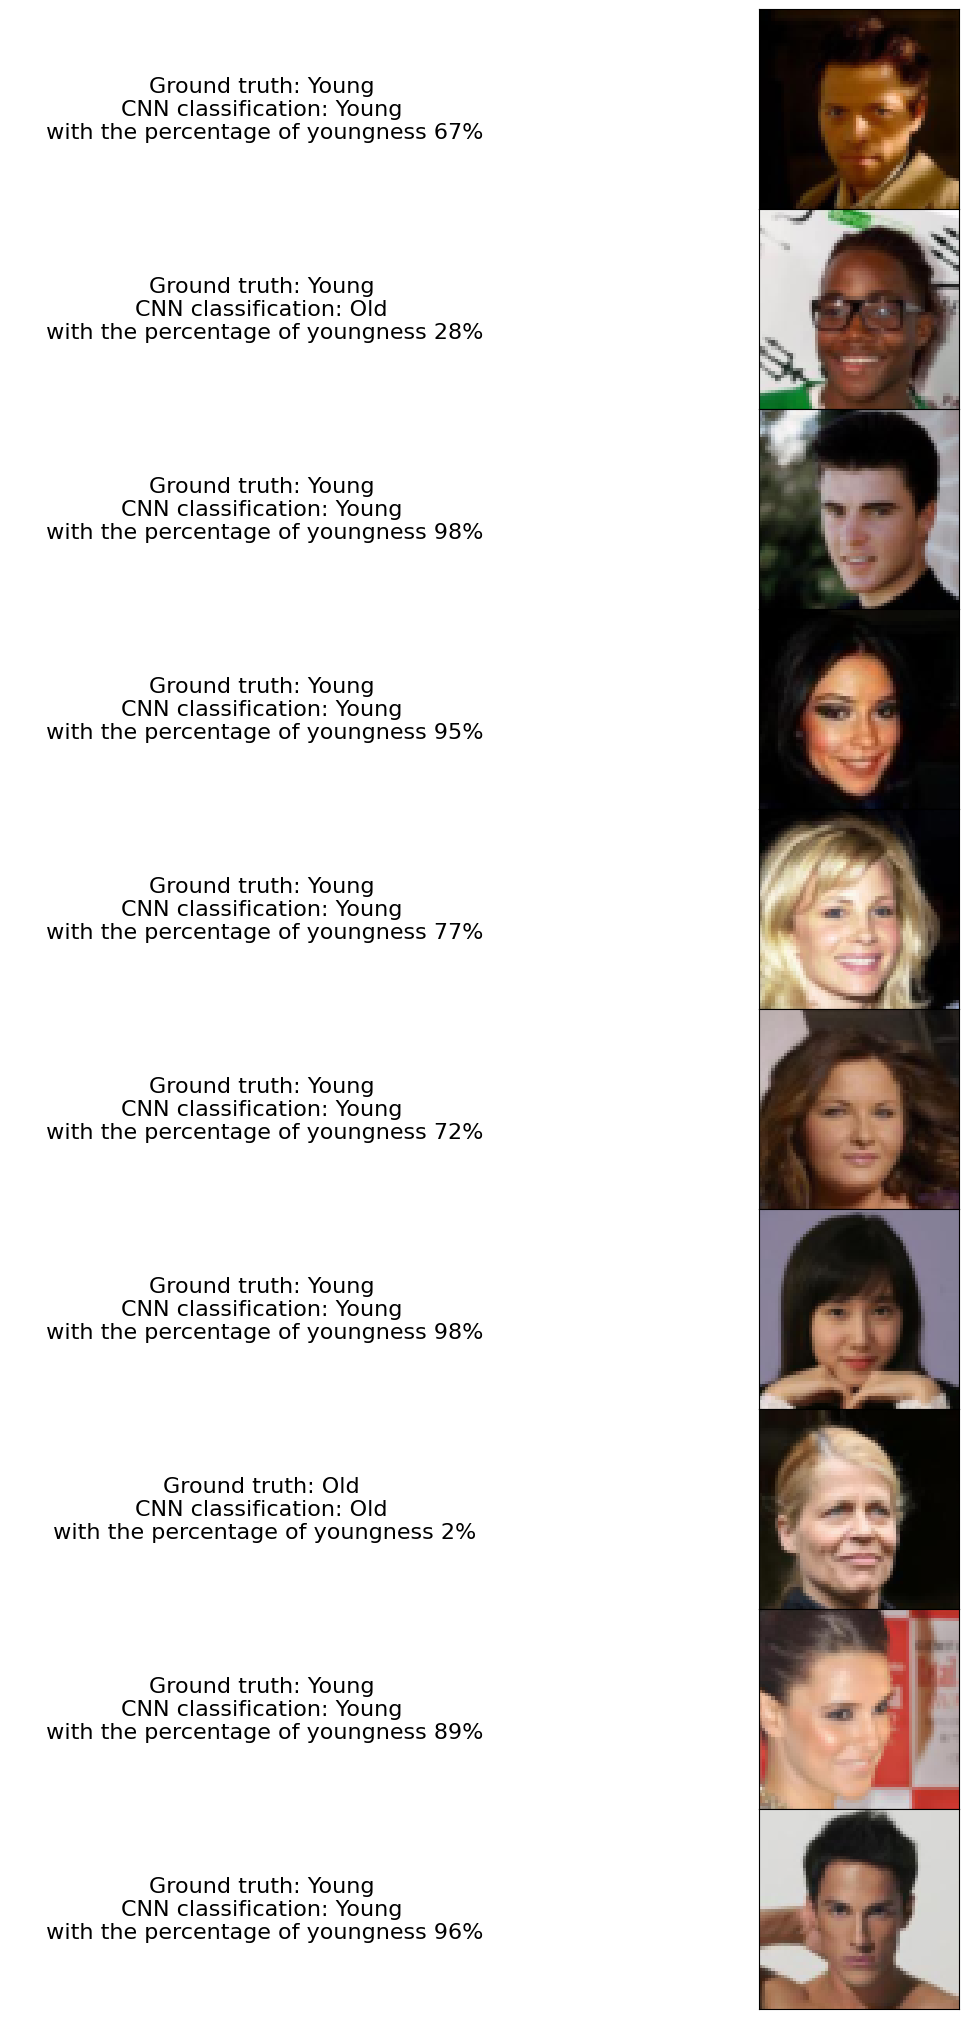

In [51]:
model = load_model()
test(model)